| Module 5 Assignment | 
|---------------------|
| Northeastern University |
|---------------------|
| by Elvin Aghammadzada|
|---------------------|
| for class EAI6010_20473 Applications of AI |
|---------------------| 
| 25/03/2023



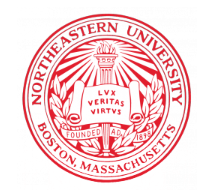

# Introduction

Wavefront planner - Wavefront algorithm is yet another path planning and optimization methods for finding the best path from start to the goal by also considering any obstacles across the map. Wavefront is a breadth first search algirithm and unlike depth first search, it always finds a way out to the destination rather than getting stuck in a local maze or an obstacle. Simplest idea behind this algorithm is to mark the cells based on their distance from the start cell and backtrack traversing to destination. 

# Body/Analysis

## 1. Using Python, create a script to find the shortest path from point S (start) to point G (goal) through a
discretized workspace (6 rows by 12 columns) such as this (“.” designates a cell of free space, “X” represents a
cell fully occupied by an obstacle). Use 4-connectivity (research the subject of connectivity, e.g., here):

```
S . . . . . . . . . . .
. . . . . . . . . . . .
. . . X X X X X X . . .
. . . X X X X X X . . .
. . . . . . . . . . . .
. . . . . . . . . . . G
```

In [12]:
obstacle_grid_custom = [[0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,1,1,1,1,1,1,0,0,0],
 [0,0,0,1,1,1,1,1,1,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0]]

## 2. Find a way to visualize the calculated path, including the path length, with the final state of the wave expansion.


In [12]:
import numpy as np
import random
import math

PI = math.pi

class Grassfire:
    '''Class is a container for constants and methods we'll use
        to create, modify, and plot a 2D grid of pixels
        demonstrating the grassfire path-planning algorithm.
    '''

    START = 0
    DEST = -1     # destination
    UNVIS = -2    # unvisited
    OBST = -3     # obstacle
    PATH = -4

    # Each of the above cell values is represented by an RGB color
    # on the plot. COLOR_VIS refers to visited cells (value > 0).
    COLOR_START = np.array([0, 0.75, 0])
    COLOR_DEST = np.array([0.75, 0, 0])
    COLOR_UNVIS = np.array([1, 1, 1])
    COLOR_VIS = np.array([0, 0.5, 1])
    COLOR_OBST = np.array([0, 0, 0])
    COLOR_PATH = np.array([1, 1, 0])

    def random_grid(self, rows=16, cols=16, obstacleProb=0.3):
        '''Return a 2D numpy array representing a grid of randomly placed
        obstacles (where the likelihood of any cell being an obstacle
        is given by obstacleProb) and randomized start/destination cells.
        '''
        # obstacleGrid = np.random.random_sample((rows, cols))


        obstacleGrid = [[0,0,0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,1,1,1,1,1,1,0,0,0],
                        [0,0,0,1,1,1,1,1,1,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0,0,0]]
        obstacleGrid = np.array(obstacleGrid)

        grid = Grassfire.UNVIS * np.ones((rows, cols), dtype=np.int)
        grid[obstacleGrid >= obstacleProb] = self.OBST

        # Randomly set start and destination cells.
        self.set_start_dest(grid)
        return grid

    def set_start_dest(self, grid):
        '''For a given grid, randomly select start and destination cells.'''
        (rows, cols) = grid.shape

        # Remove existing start and dest cells, if any.
        grid[grid == Grassfire.START] = Grassfire.UNVIS
        grid[grid == Grassfire.DEST] = Grassfire.UNVIS

        # Randomize start cell.
        validStartCell = False
        while not validStartCell:
            startIndex = random.randint(0, rows * cols - 1)
            startIndices = np.unravel_index(startIndex, (rows, cols))
            if grid[startIndices] != Grassfire.OBST:
                validStartCell = True
                grid[startIndices] = Grassfire.START

        # Randomize destination cell.
        validDestCell = False
        while not validDestCell:
            destIndex = random.randint(0, rows * cols - 1)
            destIndices = np.unravel_index(destIndex, (rows, cols))
            if grid[destIndices] != Grassfire.START and grid[destIndices] != Grassfire.OBST:
                validDestCell = True
                grid[destIndices] = Grassfire.DEST

    def color_grid(self, grid):
        '''Return MxNx3 pixel array ("color grid") corresponding to a grid.'''
        (rows, cols) = grid.shape
        colorGrid = np.zeros((rows, cols, 3), dtype=np.float)

        colorGrid[grid == Grassfire.OBST, :] = Grassfire.COLOR_OBST
        colorGrid[grid == Grassfire.UNVIS, :] = Grassfire.COLOR_UNVIS
        colorGrid[grid == Grassfire.START, :] = Grassfire.COLOR_START
        colorGrid[grid == Grassfire.DEST, :] = Grassfire.COLOR_DEST
        colorGrid[grid > Grassfire.START, :] = Grassfire.COLOR_VIS
        colorGrid[grid == Grassfire.PATH, :] = Grassfire.COLOR_PATH
        return colorGrid

    def reset_grid(self, grid):
        '''Reset cells that are not OBST, START, or DEST to UNVIS.'''
        cellsToReset = ~((grid == Grassfire.OBST) + (grid == Grassfire.START)
            + (grid == Grassfire.DEST))
        grid[cellsToReset] = Grassfire.UNVIS

    def _check_adjacent(self, grid, cell, currentDepth):
        '''For given grid, check the cells adjacent to a given
            cell. If any have a depth (positive int) greater
            than the current depth, update them with the current
            depth, where depth represents distance from start cell.
            If destination found, return DEST constant; else, return
            number of adjacent cells updated.
        '''
        (rows, cols) = grid.shape

        # Track how many adjacent cells are updated.
        numCellsUpdated = 0

        # From the current cell, examine, using sin and cos:
        # cell to right (col + 1), cell below (row + 1),
        # cell to left (col - 1), cell above (row - 1).
        for i in range(4):
            rowToCheck = cell[0] + int(math.sin((PI/2) * i))
            colToCheck = cell[1] + int(math.cos((PI/2) * i))

            # Ensure cell is within bounds of grid.
            if not (0 <= rowToCheck < rows and 0 <= colToCheck < cols):
                continue
            # Check if destination found.
            elif grid[rowToCheck, colToCheck] == Grassfire.DEST:
                return Grassfire.DEST
            # If adjacent cell unvisited or depth > currentDepth + 1,
            # mark with new depth.
            elif (grid[rowToCheck, colToCheck] == Grassfire.UNVIS
                or grid[rowToCheck, colToCheck] > currentDepth + 1):
                grid[rowToCheck, colToCheck] = currentDepth + 1
                numCellsUpdated += 1
        return numCellsUpdated

    def _backtrack(self, grid, cell, currentDepth):
        '''This function is used if the destination is found. Similar
            to _check_adjacent(), but returns coordinates of first
            surrounding cell whose value matches "currentDepth", ie,
            the next cell along the path from destination to start.
        '''
        (rows, cols) = grid.shape

        for i in range(4):
            rowToCheck = cell[0] + int(math.sin((PI/2) * i))
            colToCheck = cell[1] + int(math.cos((PI/2) * i))

            if not (0 <= rowToCheck < rows and 0 <= colToCheck < cols):
                continue
            elif grid[rowToCheck, colToCheck] == currentDepth:
                nextCell = (rowToCheck, colToCheck)
                grid[nextCell] = Grassfire.PATH
                return nextCell

    def find_path(self, grid):
        '''Execute grassfire algorithm by spreading from the start cell out.
            If destination is found, use _backtrack() to trace path from
            destination back to start. Returns a generator function to
            allow stepping through and animating the algorithm.
        '''
        nonlocalDict = {'grid': grid}
        def find_path_generator():
            grid = nonlocalDict['grid']
            depth = 0
            destFound = False
            cellsExhausted = False

            while (not destFound) and (not cellsExhausted):
                numCellsModified = 0
                depthIndices = np.where(grid == depth)
                matchingCells = list(zip(depthIndices[0], depthIndices[1]))

                for cell in matchingCells:
                    adjacentVal = self._check_adjacent(grid, cell, depth)
                    if adjacentVal == Grassfire.DEST:
                        destFound = True
                        break
                    else:
                        numCellsModified += adjacentVal

                if numCellsModified == 0:
                    cellsExhausted = True
                elif not destFound:
                    depth += 1
                yield

            if destFound:
                destCell = np.where(grid == Grassfire.DEST)
                backtrackCell = (destCell[0].item(), destCell[1].item())
                while depth > 0:
                    # Work backwards until return to start cell.
                    nextCell = self._backtrack(grid, backtrackCell, depth)
                    backtrackCell = nextCell
                    depth -= 1
                    yield
        return find_path_generator

<ipython-input-12-739e0dc41b8b>:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  grid = Grassfire.UNVIS * np.ones((rows, cols), dtype=np.int)
<ipython-input-12-739e0dc41b8b>:80: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

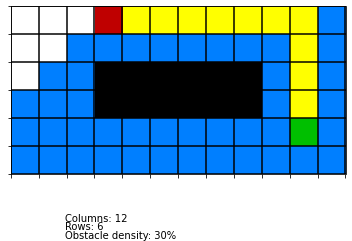

In [13]:
from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
from IPython.display import HTML

from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# from Grassfire import Grassfire
# Initialize grid rows, columns, and obstacle probability.
rows = 6
cols = 12
obstProb = 0.3

# Instantiate Grassfire class. Initialize a grid and colorGrid.
Grassfire = Grassfire()
grid = Grassfire.random_grid(rows=rows, cols=cols, obstacleProb=obstProb)
colorGrid = Grassfire.color_grid(grid)

# Initialize figure, imshow object, and axis.
fig = plt.figure()
gridPlot = plt.imshow(colorGrid, interpolation='nearest')
ax = gridPlot._axes
ax.grid(visible=True, ls='solid', color='k', lw=1.5)
ax.set_xticklabels([])
ax.set_yticklabels([])

# Initialize text annotations to display obstacle probability, rows, cols.
obstText = ax.annotate('', (0.15, 0.01), xycoords='figure fraction')
colText = ax.annotate('', (0.15, 0.04), xycoords='figure fraction')
rowText = ax.annotate('', (0.15, 0.07), xycoords='figure fraction')

def set_axis_properties(rows, cols):
    '''Set axis/imshow plot properties based on number of rows, cols.'''
    ax.set_xlim((0, cols))
    ax.set_ylim((rows, 0))
    ax.set_xticks(np.arange(0, cols+1, 1))
    ax.set_yticks(np.arange(0, rows+1, 1))
    gridPlot.set_extent([0, cols, 0, rows])

def update_annotations(rows, cols, obstProb):
    '''Update annotations with obstacle probability, rows, cols.'''
    obstText.set_text('Obstacle density: {:.0f}%'.format(obstProb * 100))
    colText.set_text('Rows: {:d}'.format(rows))
    rowText.set_text('Columns: {:d}'.format(cols))

set_axis_properties(rows, cols)
update_annotations(rows, cols, obstProb)

# Disable default figure key bindings.
fig.canvas.mpl_disconnect(fig.canvas.manager.key_press_handler_id)

# Functions init_anim() and update_anim() are for use with FuncAnimation.
def init_anim():
    '''Plot grid in its initial state by resetting "grid".'''
    Grassfire.reset_grid(grid)
    colorGrid = Grassfire.color_grid(grid)
    gridPlot.set_data(colorGrid)

def update_anim(dummyFrameArgument):
    '''Update plot based on values in "grid" ("grid" is updated
        by the generator--this function simply passes "grid" to
        the color_grid() function to get an image array).
    '''
    colorGrid = Grassfire.color_grid(grid)
    gridPlot.set_data(colorGrid)

# Create animation object. Supply generator function to frames.
ani = animation.FuncAnimation(fig, update_anim,
    init_func=init_anim, frames=Grassfire.find_path(grid),
    repeat=True, interval=150)

ani.save('BrowniamMotion2.gif', writer = "pillow", fps=10 )
HTML(ani.to_html5_video())
# Turn on interactive plotting and show figure.
plt.ion()
plt.show(block=True)




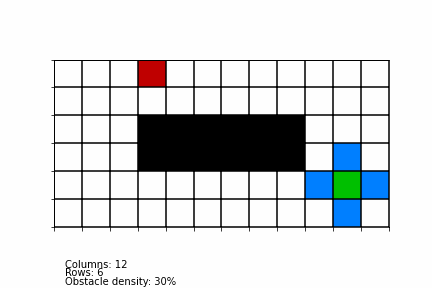

## 3. Change to 8-connectivity, recalculate, visualize, and interpret the results.


<ipython-input-12-739e0dc41b8b>:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  grid = Grassfire.UNVIS * np.ones((rows, cols), dtype=np.int)
<ipython-input-12-739e0dc41b8b>:80: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

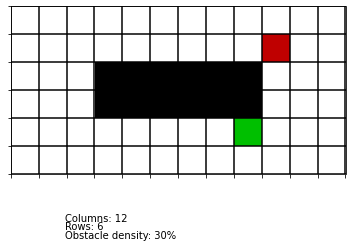

In [16]:
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# from Grassfire import Grassfire
# Initialize grid rows, columns, and obstacle probability.
rows = 6
cols = 12
obstProb = 0.3

# Instantiate Grassfire class. Initialize a grid and colorGrid.
# Grassfire = Grassfire()
grid = Grassfire.random_grid(rows=rows, cols=cols, obstacleProb=obstProb)
colorGrid = Grassfire.color_grid(grid)

# Initialize figure, imshow object, and axis.
fig = plt.figure()
gridPlot = plt.imshow(colorGrid, interpolation='nearest')
ax = gridPlot._axes
ax.grid(visible=True, ls='solid', color='k', lw=1.5)
ax.set_xticklabels([])
ax.set_yticklabels([])

# Initialize text annotations to display obstacle probability, rows, cols.
obstText = ax.annotate('', (0.15, 0.01), xycoords='figure fraction')
colText = ax.annotate('', (0.15, 0.04), xycoords='figure fraction')
rowText = ax.annotate('', (0.15, 0.07), xycoords='figure fraction')

def set_axis_properties(rows, cols):
    '''Set axis/imshow plot properties based on number of rows, cols.'''
    ax.set_xlim((0, cols))
    ax.set_ylim((rows, 0))
    ax.set_xticks(np.arange(0, cols+1, 1))
    ax.set_yticks(np.arange(0, rows+1, 1))
    gridPlot.set_extent([0, cols, 0, rows])

def update_annotations(rows, cols, obstProb):
    '''Update annotations with obstacle probability, rows, cols.'''
    obstText.set_text('Obstacle density: {:.0f}%'.format(obstProb * 100))
    colText.set_text('Rows: {:d}'.format(rows))
    rowText.set_text('Columns: {:d}'.format(cols))

set_axis_properties(rows, cols)
update_annotations(rows, cols, obstProb)

# Disable default figure key bindings.
fig.canvas.mpl_disconnect(fig.canvas.manager.key_press_handler_id)

# Functions init_anim() and update_anim() are for use with FuncAnimation.
def init_anim():
    '''Plot grid in its initial state by resetting "grid".'''
    Grassfire.reset_grid(grid)
    colorGrid = Grassfire.color_grid(grid)
    gridPlot.set_data(colorGrid)

def update_anim(dummyFrameArgument):
    '''Update plot based on values in "grid" ("grid" is updated
        by the generator--this function simply passes "grid" to
        the color_grid() function to get an image array).
    '''
    colorGrid = Grassfire.color_grid(grid)
    gridPlot.set_data(colorGrid)

# Create animation object. Supply generator function to frames.
ani = animation.FuncAnimation(fig, update_anim,
    init_func=init_anim, frames=Grassfire.find_path(grid),
    repeat=True, interval=150)

# Turn on interactive plotting and show figure.
plt.ion()
plt.show(block=True)

## 4. Modify the code so that the coordinates of “S” and “G” are randomly generated (obviously, the locations of
those cannot be in the obstacle area). Run this simulation in a loop. At the end of each simulation, display the
path. For the sake of the exercise, repeat the loop just three times. Either connectivity (4 or 8) is acceptable. For
simplicity, you can restrict randomly generated “S”s to the left half and “G”s to the right half.


In [8]:
import numpy as np
import random
import math

PI = math.pi

class Grassfire:
    '''Class is a container for constants and methods we'll use
        to create, modify, and plot a 2D grid of pixels
        demonstrating the grassfire path-planning algorithm.
    '''

    START = 0
    DEST = -1     # destination
    UNVIS = -2    # unvisited
    OBST = -3     # obstacle
    PATH = -4

    # Each of the above cell values is represented by an RGB color
    # on the plot. COLOR_VIS refers to visited cells (value > 0).
    COLOR_START = np.array([0, 0.75, 0])
    COLOR_DEST = np.array([0.75, 0, 0])
    COLOR_UNVIS = np.array([1, 1, 1])
    COLOR_VIS = np.array([0, 0.5, 1])
    COLOR_OBST = np.array([0, 0, 0])
    COLOR_PATH = np.array([1, 1, 0])

    def random_grid(self, rows=16, cols=16, obstacleProb=0.3):
        '''Return a 2D numpy array representing a grid of randomly placed
        obstacles (where the likelihood of any cell being an obstacle
        is given by obstacleProb) and randomized start/destination cells.
        '''
        # obstacleGrid = np.random.random_sample((rows, cols))


        obstacleGrid = [[0,0,0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,1,1,1,1,1,1,0,0,0],
                        [0,0,0,1,1,1,1,1,1,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,0,0,0,0]]
        obstacleGrid = np.array(obstacleGrid)

        grid = Grassfire.UNVIS * np.ones((rows, cols), dtype=np.int)
        grid[obstacleGrid >= obstacleProb] = self.OBST

        # Randomly set start and destination cells.
        self.set_start_dest(grid)
        return grid

    def set_start_dest(self, grid):
        '''For a given grid, randomly select start and destination cells.'''
        (rows, cols) = grid.shape

        # Remove existing start and dest cells, if any.
        grid[grid == Grassfire.START] = Grassfire.UNVIS
        grid[grid == Grassfire.DEST] = Grassfire.UNVIS

        # Randomize start cell.
        validStartCell = False
        while not validStartCell:
            startIndex = random.randint(0, rows * cols - 1)
            startIndices = np.unravel_index(startIndex, (rows, cols))
            if grid[startIndices] != Grassfire.OBST:
                validStartCell = True
                grid[startIndices] = Grassfire.START

        # Randomize destination cell.
        validDestCell = False
        while not validDestCell:
            destIndex = random.randint(0, rows * cols - 1)
            destIndices = np.unravel_index(destIndex, (rows, cols))
            if grid[destIndices] != Grassfire.START and grid[destIndices] != Grassfire.OBST:
                validDestCell = True
                grid[destIndices] = Grassfire.DEST

    def color_grid(self, grid):
        '''Return MxNx3 pixel array ("color grid") corresponding to a grid.'''
        (rows, cols) = grid.shape
        colorGrid = np.zeros((rows, cols, 3), dtype=np.float)

        colorGrid[grid == Grassfire.OBST, :] = Grassfire.COLOR_OBST
        colorGrid[grid == Grassfire.UNVIS, :] = Grassfire.COLOR_UNVIS
        colorGrid[grid == Grassfire.START, :] = Grassfire.COLOR_START
        colorGrid[grid == Grassfire.DEST, :] = Grassfire.COLOR_DEST
        colorGrid[grid > Grassfire.START, :] = Grassfire.COLOR_VIS
        colorGrid[grid == Grassfire.PATH, :] = Grassfire.COLOR_PATH
        return colorGrid

    def reset_grid(self, grid):
        '''Reset cells that are not OBST, START, or DEST to UNVIS.'''
        cellsToReset = ~((grid == Grassfire.OBST) + (grid == Grassfire.START)
            + (grid == Grassfire.DEST))
        grid[cellsToReset] = Grassfire.UNVIS

    def _check_adjacent(self, grid, cell, currentDepth):
        '''For given grid, check the cells adjacent to a given
            cell. If any have a depth (positive int) greater
            than the current depth, update them with the current
            depth, where depth represents distance from start cell.
            If destination found, return DEST constant; else, return
            number of adjacent cells updated.
        '''
        (rows, cols) = grid.shape

        # Track how many adjacent cells are updated.
        numCellsUpdated = 0

        # From the current cell, examine, using sin and cos:
        # cell to right (col + 1), cell below (row + 1),
        # cell to left (col - 1), cell above (row - 1).
        for i in range(4):
            rowToCheck = cell[0] + int(math.sin((PI/2) * i))
            colToCheck = cell[1] + int(math.cos((PI/2) * i))

            # Ensure cell is within bounds of grid.
            if not (0 <= rowToCheck < rows and 0 <= colToCheck < cols):
                continue
            # Check if destination found.
            elif grid[rowToCheck, colToCheck] == Grassfire.DEST:
                return Grassfire.DEST
            # If adjacent cell unvisited or depth > currentDepth + 1,
            # mark with new depth.
            elif (grid[rowToCheck, colToCheck] == Grassfire.UNVIS
                or grid[rowToCheck, colToCheck] > currentDepth + 1):
                grid[rowToCheck, colToCheck] = currentDepth + 1
                numCellsUpdated += 1
        return numCellsUpdated

    def _backtrack(self, grid, cell, currentDepth):
        '''This function is used if the destination is found. Similar
            to _check_adjacent(), but returns coordinates of first
            surrounding cell whose value matches "currentDepth", ie,
            the next cell along the path from destination to start.
        '''
        (rows, cols) = grid.shape

        for i in range(4):
            rowToCheck = cell[0] + int(math.sin((PI/2) * i))
            colToCheck = cell[1] + int(math.cos((PI/2) * i))

            if not (0 <= rowToCheck < rows and 0 <= colToCheck < cols):
                continue
            elif grid[rowToCheck, colToCheck] == currentDepth:
                nextCell = (rowToCheck, colToCheck)
                grid[nextCell] = Grassfire.PATH
                return nextCell

    def find_path(self, grid):
        '''Execute grassfire algorithm by spreading from the start cell out.
            If destination is found, use _backtrack() to trace path from
            destination back to start. Returns a generator function to
            allow stepping through and animating the algorithm.
        '''
        nonlocalDict = {'grid': grid}
        def find_path_generator():
            grid = nonlocalDict['grid']
            depth = 0
            destFound = False
            cellsExhausted = False

            while (not destFound) and (not cellsExhausted):
                numCellsModified = 0
                depthIndices = np.where(grid == depth)
                matchingCells = list(zip(depthIndices[0], depthIndices[1]))

                for cell in matchingCells:
                    adjacentVal = self._check_adjacent(grid, cell, depth)
                    if adjacentVal == Grassfire.DEST:
                        destFound = True
                        break
                    else:
                        numCellsModified += adjacentVal

                if numCellsModified == 0:
                    cellsExhausted = True
                elif not destFound:
                    depth += 1
                yield

            if destFound:
                destCell = np.where(grid == Grassfire.DEST)
                backtrackCell = (destCell[0].item(), destCell[1].item())
                while depth > 0:
                    # Work backwards until return to start cell.
                    nextCell = self._backtrack(grid, backtrackCell, depth)
                    backtrackCell = nextCell
                    depth -= 1
                    yield
        return find_path_generator

In [9]:
from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
from IPython.display import HTML

<ipython-input-8-739e0dc41b8b>:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  grid = Grassfire.UNVIS * np.ones((rows, cols), dtype=np.int)
<ipython-input-8-739e0dc41b8b>:80: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 

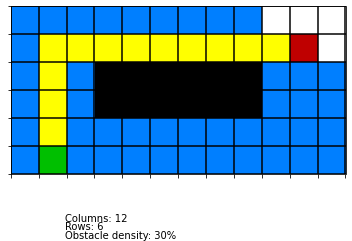

In [10]:
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# from Grassfire import Grassfire
# Initialize grid rows, columns, and obstacle probability.
rows = 6
cols = 12
obstProb = 0.3

# Instantiate Grassfire class. Initialize a grid and colorGrid.
Grassfire = Grassfire()
grid = Grassfire.random_grid(rows=rows, cols=cols, obstacleProb=obstProb)
colorGrid = Grassfire.color_grid(grid)

# Initialize figure, imshow object, and axis.
fig = plt.figure()
gridPlot = plt.imshow(colorGrid, interpolation='nearest')
ax = gridPlot._axes
ax.grid(visible=True, ls='solid', color='k', lw=1.5)
ax.set_xticklabels([])
ax.set_yticklabels([])

# Initialize text annotations to display obstacle probability, rows, cols.
obstText = ax.annotate('', (0.15, 0.01), xycoords='figure fraction')
colText = ax.annotate('', (0.15, 0.04), xycoords='figure fraction')
rowText = ax.annotate('', (0.15, 0.07), xycoords='figure fraction')

def set_axis_properties(rows, cols):
    '''Set axis/imshow plot properties based on number of rows, cols.'''
    ax.set_xlim((0, cols))
    ax.set_ylim((rows, 0))
    ax.set_xticks(np.arange(0, cols+1, 1))
    ax.set_yticks(np.arange(0, rows+1, 1))
    gridPlot.set_extent([0, cols, 0, rows])

def update_annotations(rows, cols, obstProb):
    '''Update annotations with obstacle probability, rows, cols.'''
    obstText.set_text('Obstacle density: {:.0f}%'.format(obstProb * 100))
    colText.set_text('Rows: {:d}'.format(rows))
    rowText.set_text('Columns: {:d}'.format(cols))

set_axis_properties(rows, cols)
update_annotations(rows, cols, obstProb)

# Disable default figure key bindings.
fig.canvas.mpl_disconnect(fig.canvas.manager.key_press_handler_id)

# Functions init_anim() and update_anim() are for use with FuncAnimation.
def init_anim():
    '''Plot grid in its initial state by resetting "grid".'''
    Grassfire.reset_grid(grid)
    colorGrid = Grassfire.color_grid(grid)
    gridPlot.set_data(colorGrid)

def update_anim(dummyFrameArgument):
    '''Update plot based on values in "grid" ("grid" is updated
        by the generator--this function simply passes "grid" to
        the color_grid() function to get an image array).
    '''
    colorGrid = Grassfire.color_grid(grid)
    gridPlot.set_data(colorGrid)

# Create animation object. Supply generator function to frames.
ani = animation.FuncAnimation(fig, update_anim,
    init_func=init_anim, frames=Grassfire.find_path(grid),
    repeat=True, interval=150)


ani.save('BrowniamMotion.gif', writer = "pillow", fps=10 )
HTML(ani.to_html5_video())
# Turn on interactive plotting and show figure.
plt.ion()
plt.show(block=True)

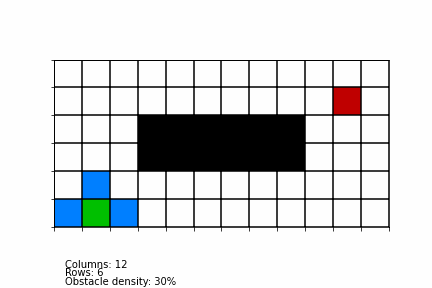

## Reflect on the results 

* From the experiments above, and after having some unerstanding about the Wavefront algorithm, I now realized that breadth first algorithms are usually superior to the depth first algorithms. One of the reasons is, DFS methods might potentially not reach the solution in some edge cases even if it exists. While BFS will eventually get there after looking up through all the search space.

* Learning about 8-point connectivity was another point I can mention here. It allows the robot or agent to move in diagonal direction which can potentially optimize the whole procedure. The fact that this is applicable to the real-world problems such as path planning in logistics amazes me.

# References

    1. Bhavya, et. al, (2019). Wave front Method Based Path Planning Algorithm for Mobile Robots.from https://www3.cs.stonybrook.edu/~bghai/docs/Wave%20Front%20Method%20Based%20Path%20Planning%20Algorithm%20for%20Mobile%20Robots.pdf

    2. Steven, L. (2020). Wavefront propagation algorithms from http://lavalle.pl/planning/node372.html

    3. Najam, S. (2017). Animating the Grassfire path-planning algorithm, from https://nrsyed.com/2017/12/30/animating-the-grassfire-path-planning-algorithm/